<a href="https://colab.research.google.com/github/Iramuk-ganh/rl/blob/main/reinforce_policy_gradient_method_policy_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys, os
if 'google.colab' in sys.modules:
    %tensorflow_version 1.x
    
    if not os.path.exists('.setup_complete'):
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash

        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/grading.py -O ../grading.py
        !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/coursera/week5_policy_based/submit.py

        !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

TensorFlow 1.x selected.
Selecting previously unselected package xvfb.
(Reading database ... 155229 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Starting virtual X frame buffer: Xvfb.


In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
env = gym.make("CartPole-v0")

In [8]:
env

😌hasattr(obj, name)

Return whether the object has an attribute with the given name.
This is done by calling getattr(obj, name) and catching AttributeError.

In [7]:
# gym compatibility: unwrap TimeLimit
if hasattr(env, '_max_episode_steps'):
    env = env.env

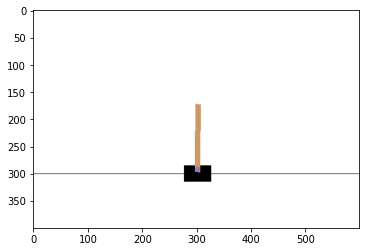

In [10]:
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape
plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE


For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

For numerical stability, please __do not include the softmax layer into your network architecture__.
We'll use softmax or log-softmax where appropriate.

In [11]:
import tensorflow as tf

😌tf.InteractiveSession()
A TensorFlow Session for use in interactive contexts, such as a shell.
The only difference with a regular Session is that an InteractiveSession
installs itself as the default session on construction.
The methods tf.Tensor.eval
and tf.Operation.run
will use that session to run ops.

###tf.InteractiveSession()

tf.Session
🔗https://www.tensorflow.org/api_docs/python/tf/compat/v1/Session

In [12]:
sess_eg = tf.InteractiveSession() 

In [14]:
a = tf.constant(5.0)
b = tf.constant(6.0)
c = a*b
# We can just use 'c.eval()' without passing 'sess'
print(c.eval())
sess_eg.close()

30.0


###Default session for REINFORCE

In [15]:
sess = tf.InteractiveSession()

###tf.placeholder

Inserts a placeholder for a tensor that will be always fed.
🔗https://www.tensorflow.org/api_docs/python/tf/compat/v1/placeholder

In [16]:
# create input variables. We only need <s, a, r> for REINFORCE
ph_states = tf.placeholder('float32', (None,)+state_dim, name = "states")
ph_actions = tf.placeholder('int32', name="action_ids")
ph_cumulative_rewards = tf.placeholder('float32', name="cumulative_returns")

In [24]:
import keras
from keras.models import Sequential
import keras.layers as L

In [59]:
#define network graph using raw TF, Keras, or any other library you prefer
network = keras.models.Sequential()
network.add(L.InputLayer(state_dim))

network.add(L.Dense(32, activation='relu', input_shape = state_dim))
network.add(L.Dense(32, activation='relu'))
network.add(L.Dense(n_actions, activation='linear'))

In [60]:
ph_states

<tf.Tensor 'states:0' shape=(?, 4) dtype=float32>

In [61]:
#logits = symbolic outputs of your network _before_ softmax
logits = network(ph_states)#action-values for all actions

policy = tf.nn.softmax(logits)#softmax() computes softmax activations
log_policy = tf.nn.log_softmax(logits)#log_softmax() computes log softmax activations

###sess.run()
🔗https://www.tensorflow.org/api_docs/python/tf/compat/v1/Session
🔗https://stackoverflow.com/questions/51401935/arguments-to-tensorflow-session-run-do-you-pass-operations/51402747

😌tf.global_variables_initializer()

Returns an Op that initializes global variables.
This is just a shortcut for variables_initializer(global_variables()).

In [62]:
sess.run(tf.global_variables_initializer())

In [63]:
def predict_probs(states):
    """ 
    Predict action probabilities given states.
    :param states: numpy array of shape [batch, state_shape]
    :returns: numpy array of shape [batch, n_actions]
    """
    return policy.eval({ph_states: [states]})[0]

### Play the game

We can now use our newly built agent to play the game.

In [64]:
import numpy as np

In [82]:
def generate_session(env, t_max=1000):
    """ 
    Play a full session with REINFORCE agent.
    Returns sequences of states, actions, and rewards.
    """
    # arrays to record session
    states, actions, rewards = [], [], []
    s = env.reset()

    for t in range(t_max):
       # action probabilities array aka pi(a|s)
       action_probs = predict_probs(s)

       # Sample action with given probabilities.
       a = np.random.choice(n_actions, 1, p=action_probs)[0]
       new_s, r, done, info = env.step(a)

       # record session history to train later
       states.append(s)
       actions.append(a)
       rewards.append(r)

       s = new_s
       if done:
            break
    return states, actions, rewards

In [83]:
# test it
states, actions, rewards = generate_session(env)

### Computing cumulative rewards

$$
\begin{align*}
G_t &= r_t + \gamma r_{t + 1} + \gamma^2 r_{t + 2} + \ldots \\
&= \sum_{i = t}^T \gamma^{i - t} r_i \\
&= r_t + \gamma * G_{t + 1}
\end{align*}
$$

In [84]:
from collections import deque

In [85]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    Take a list of immediate rewards r(s,a) for the whole session 
    and compute cumulative returns (a.k.a. G(s,a) in Sutton '16).

    G_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    A simple way to compute cumulative rewards is to iterate from the last
    to the first timestep and compute G_t = r_t + gamma*G_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    returns = deque([rewards[-1]])#cumulative_rewards
    for i in range(len(rewards)-2, -1, -1):#range(start, stop, step)
      returns.appendleft(rewards[i] + gamma*returns[0])

    return returns

In [86]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9),
    [1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, -2, 3, -4, 0], gamma=0.5),
    [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(
    get_cumulative_rewards([0, 0, 1, 2, 3, 4, 0], gamma=0),
    [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


#### Loss function and updates

We now need to define objective and update over policy gradient.

Our objective function is

$$ J \approx  { 1 \over N } \sum_{s_i,a_i} G(s_i,a_i) $$

REINFORCE defines a way to compute the gradient of the expected reward with respect to policy parameters. The formula is as follows:

$$ \nabla_\theta \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \nabla_\theta \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

We can abuse Tensorflow's capabilities for automatic differentiation by defining our objective function as follows:

$$ \hat J(\theta) \approx { 1 \over N } \sum_{s_i, a_i} \log \pi_\theta (a_i \mid s_i) \cdot G_t(s_i, a_i) $$

When you compute the gradient of that function with respect to network weights $\theta$, it will become exactly the policy gradient.

In [87]:
tf.shape(log_policy)

<tf.Tensor 'Shape_4:0' shape=(2,) dtype=int32>

###tf.stack()
😌tf.stack()
Stacks a list of rank-R tensors into one rank-(R+1) tensor.

Packs the list of tensors in values into a tensor with rank one higher than
each tensor in values, by packing them along the axis dimension.
Given a list of length N of tensors of shape (A, B, C);

if axis == 0 then the output tensor will have the shape (N, A, B, C).
if axis == 1 then the output tensor will have the shape (A, N, B, C).
Etc.

In [88]:
x = tf.constant([1, 4])
y = tf.constant([2, 5])
z = tf.constant([3, 6])
a=tf.stack([x, y, z])  # [[1, 4], [2, 5], [3, 6]] (Pack along first dim.)
b=tf.stack([x, y, z], axis=1)  # [[1, 2, 3], [4, 5, 6]]
a,b

(<tf.Tensor 'stack_6:0' shape=(3, 2) dtype=int32>,
 <tf.Tensor 'stack_7:0' shape=(2, 3) dtype=int32>)

###tf.gather_nd(params, indices, name=None, batch_dims=0)

😌Gather slices from params into a Tensor with shape specified by indices.

In [89]:
# This code selects the log-probabilities (log pi(a_i|s_i)) for those actions that were actually played.
indices = tf.stack([tf.range(tf.shape(log_policy)[0]), ph_actions], axis=-1)
log_policy_for_actions = tf.gather_nd(log_policy, indices)

In [90]:
# Policy objective as in the last formula. Please use reduce_mean, not reduce_sum.
# You may use log_policy_for_actions to get log probabilities for actions taken.
# Also recall that we defined ph_cumulative_rewards earlier.

J = tf.reduce_mean(log_policy_for_actions*ph_cumulative_rewards)

In [91]:
# Entropy regularization. If you don't add it, the policy will quickly deteriorate to
# being deterministic, harming exploration.

entropy = -tf.reduce_sum(policy*log_policy, 1, name="entropy")#compute entropy. Do not forget the sign!

In [92]:
# # Maximizing X is the same as minimizing -X, hence the sign.
loss = -(J + 0.1 * entropy)

update = tf.train.AdamOptimizer().minimize(loss)

In [93]:
def train_on_session(states, actions, rewards, t_max=1000):
    """given full session, trains agent with policy gradient"""
    cumulative_rewards = get_cumulative_rewards(rewards)
    update.run({
        ph_states: states,
        ph_actions: actions,
        ph_cumulative_rewards: cumulative_rewards,
    })
    return sum(rewards)

In [94]:
# Initialize optimizer parameters
sess.run(tf.global_variables_initializer())

### The actual training

In [95]:
for i in range(100):
  rewards = [train_on_session(*generate_session(env)) for _ in range(100)]

  print("mean reward: %.3f" % (np.mean(rewards)))

  if np.mean(rewards) > 300:
    print("You Win!") # but you can train even further
    break

mean reward: 26.870
mean reward: 33.920
mean reward: 64.450
mean reward: 152.720
mean reward: 398.920
You Win!


### Results & video

In [96]:
# Record sessions

import gym.wrappers

with gym.wrappers.Monitor(gym.make("CartPole-v0"), directory="videos", force=True) as env_monitor:
    sessions = [generate_session(env_monitor) for _ in range(100)]

In [97]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from IPython.display import HTML

video_names = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(video_names[-1]))  # You can also try other indices

In [100]:
from submit import submit_cartpole
submit_cartpole(generate_session, 'yonghangaashma7@gmail.com', 'IiXzYIMSxSBGZf2K')

Your average reward is 456.66 over 100 episodes
Submitted to Coursera platform. See results on assignment page!
